In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import os, sys 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import h3pandas 
sys.path.append('../../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../../scripts/')
import create_dataset_utils as cdu
import paired_embeddings_models as pem
sys.path.append('../../../cnn-land-cover/scripts/')
import land_cover_analysis as lca 
import land_cover_visualisation as lcv
import shapely
from tqdm import tqdm, tqdm_notebook
import torch
from sklearn.manifold import TSNE 


In [3]:
os.getcwd()

'/Users/t.vanderplas/repos/PECL/notebooks/try-out'

In [91]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/data/UKBMS_sent2_ds/sent2-4band/2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='all',
                              zscore_im=True, 
                              augment_image=False, mode='val')

im_enc = pem.ImageEncoder(n_species=ds.n_species, n_bands=4, freeze_resnet=True,
                             pecl_distance_metric='softmax',
                             training_method='pecl',
                             pretrained_resnet='seco')

Found 1336 out of 1455 images in the image folder.
Sorting data by name_loc.
No class weights.
seco keys: ['queue', 'queue_ptr', 'encoder_q.0.weight', 'encoder_q.1.weight', 'encoder_q.1.bias', 'encoder_q.1.running_mean', 'encoder_q.1.running_var', 'encoder_q.1.num_batches_tracked', 'encoder_q.4.0.conv1.weight', 'encoder_q.4.0.bn1.weight', 'encoder_q.4.0.bn1.bias', 'encoder_q.4.0.bn1.running_mean', 'encoder_q.4.0.bn1.running_var', 'encoder_q.4.0.bn1.num_batches_tracked', 'encoder_q.4.0.conv2.weight', 'encoder_q.4.0.bn2.weight', 'encoder_q.4.0.bn2.bias', 'encoder_q.4.0.bn2.running_mean', 'encoder_q.4.0.bn2.running_var', 'encoder_q.4.0.bn2.num_batches_tracked', 'encoder_q.4.1.conv1.weight', 'encoder_q.4.1.bn1.weight', 'encoder_q.4.1.bn1.bias', 'encoder_q.4.1.bn1.running_mean', 'encoder_q.4.1.bn1.running_var', 'encoder_q.4.1.bn1.num_batches_tracked', 'encoder_q.4.1.conv2.weight', 'encoder_q.4.1.bn2.weight', 'encoder_q.4.1.bn2.bias', 'encoder_q.4.1.bn2.running_mean', 'encoder_q.4.1.bn2.runn

/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
n_ims = 200
dist_mat_mse = np.zeros((n_ims, n_ims)) 
dist_mat_eucledian = np.zeros((n_ims, n_ims))
total_iterations = n_ims * (n_ims - 1) // 2
method_change_shape_feature = 'mean_xy'
assert method_change_shape_feature in ['flatten', 'mean_xy']

dict_encodings = {}
for ii in tqdm(range(n_ims)):
    im1 = ds[ii][0][None, :, :, :]
    encoding_1 = im_enc.forward(im1)
    # if method_change_shape_feature == 'flatten':
    #     encoding_1 = encoding_1.flatten()
    # elif method_change_shape_feature == 'mean_xy':
    #     encoding_1 = torch.mean(encoding_1, dim=(2, 3))
    # print(encoding_1.shape)
    dict_encodings[ii] = encoding_1

with tqdm_notebook(total=total_iterations) as pbar:
    for ii in range(n_ims):
        for jj in range(ii + 1, n_ims):
            encoding_1 = dict_encodings[ii]
            encoding_2 = dict_encodings[jj]
            dist_mat_mse[ii, jj] = torch.nn.functional.mse_loss(
                encoding_1, encoding_2, reduction='mean'
            ).item()
            dist_mat_eucledian[ii, jj] = torch.nn.functional.pairwise_distance(
                encoding_1, encoding_2, p=2
            ).item()        

            dist_mat_mse[jj, ii] = dist_mat_mse[ii, jj]
            dist_mat_eucledian[jj, ii] = dist_mat_eucledian[ii, jj]
            
            # Update the progress bar
            pbar.update(1)
        

100%|██████████| 200/200 [00:14<00:00, 13.34it/s]
/var/folders/vg/lgb0bh9x2yx0ny2lk_h8_ylc0000gr/T/ipykernel_46355/26300261.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=total_iterations) as pbar:


  0%|          | 0/19900 [00:00<?, ?it/s]

In [14]:
# dist_mat = dist_mat_eucledian
dist_mat = dist_mat_mse
# dist_mat = dist_mat_seco|

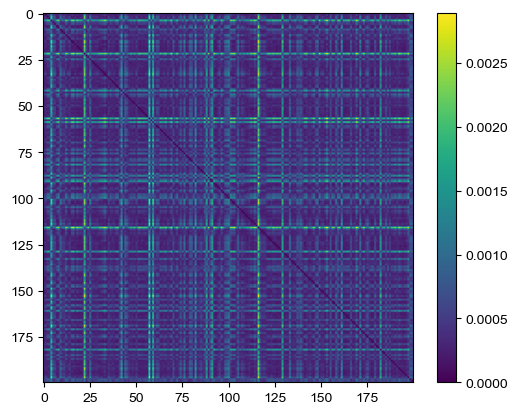

In [15]:
## set diag to nan
dist_mat[np.diag_indices_from(dist_mat)] = 0

plt.imshow(dist_mat)
plt.colorbar()

/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0, 0.5, 't-SNE 2')

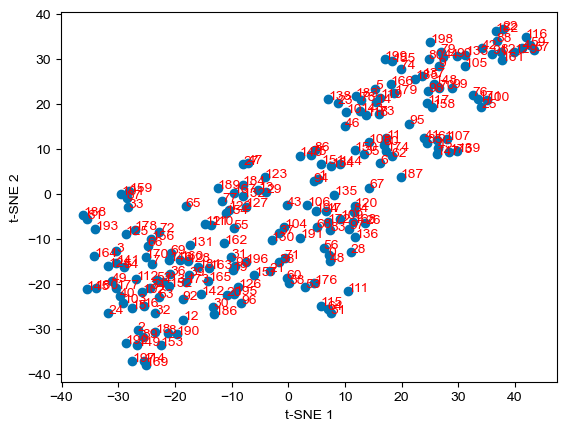

In [16]:

tsne = TSNE(n_components=2, perplexity=8, metric='precomputed')
tsne_res = tsne.fit_transform(dist_mat)

plt.scatter(tsne_res[:, 0], tsne_res[:, 1])
for i, (x, y) in enumerate(tsne_res):
    plt.text(x, y, str(i), color='red')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

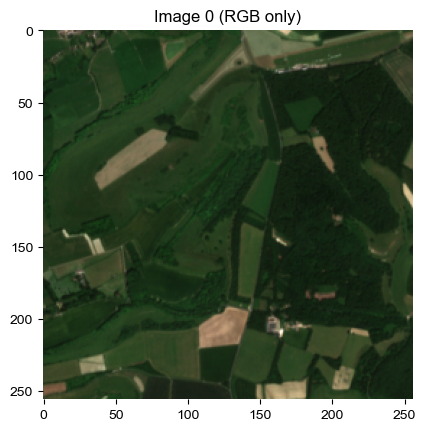

In [21]:
ds.plot_image(0)

In [93]:
# im_inds = [27, 90, 176, 150, 155, 24]
folder_save = '/Users/t.vanderplas/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/data/UKBMS_sent2_ds/sent2-4band/overview_images_2019/'
if not os.path.exists(folder_save):
    os.mkdir(folder_save)
# # k += 20
# k = 150
    
print(ds.suffix_images)
for k in range(0, len(ds), 20):
    print(k)
    im_inds = np.arange(k, k + 20)
    n_max_cols = 4 
    n_rows = int(np.ceil(len(im_inds) / n_max_cols))
    size_im = 3
    fig, ax = plt.subplots(n_rows, n_max_cols, figsize=(n_max_cols * size_im, n_rows * size_im))

    for i_plot, (ii, ax_) in enumerate(zip(im_inds, ax.flatten())):
        if ii < len(ds):
            ds.plot_image(index=ii, ax=ax_)

    for ax_ in ax.flatten():
        ax_.axis('off')

    plt.savefig(folder_save + f'ukbms_overview_{k}-{k+19}.png')
    plt.close()

['y-2019_m-06-09.tif']
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320


In [67]:
ds.df_presence.iloc

,tuple_coords,Melanargia galathea,Pieris napi,Aphantopus hyperantus,Aglais io,Polyommatus icarus,Vanessa atalanta,Lycaena phlaeas,Pararge aegeria,Gonepteryx rhamni,...,Tyria jacobaeae,Euclidia glyphica,Odezia atrata,Melitaea cinxia,Carterocephalus palaemon,Nymphalis polychloros,Nymphalis antiopa,Erebia epiphron,n_visits,name_loc
0,"(-2.165105, 50.956811)",0.297872,0.404255,0.255319,0.319149,0.744681,0.297872,0.553191,0.723404,0.765957,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47,UKBMS_loc-0000
1,"(-2.646667, 50.775285)",0.305085,0.533898,0.296610,0.271186,0.610169,0.271186,0.203390,0.805085,0.279661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118,UKBMS_loc-0001
2,"(-0.828484, 50.888106)",0.300000,0.450000,0.400000,0.250000,0.650000,0.400000,0.550000,1.000000,0.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,UKBMS_loc-0002
3,"(-1.966038, 50.59722)",0.300885,0.115044,0.185841,0.318584,0.707965,0.469027,0.247788,0.884956,0.044248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113,UKBMS_loc-0003
4,"(-0.229941, 52.409243)",0.020833,0.791667,0.291667,0.541667,0.083333,0.312500,0.020833,0.958333,0.479167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48,UKBMS_loc-0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,"(-0.751089, 51.651648)",0.272727,0.272727,0.272727,0.363636,0.545455,0.454545,0.272727,0.727273,0.272727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,UKBMS_loc-2206
1332,"(-1.872219, 53.869641)",0.000000,0.095238,0.380952,0.428571,0.000000,0.047619,0.047619,0.523810,0.047619,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,UKBMS_loc-2209
1333,"(-1.619057, 53.275874)",0.000000,0.400000,0.300000,0.450000,0.250000,0.200000,0.250000,0.300000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,UKBMS_loc-2223
1334,"(-2.036753, 50.687147)",0.000000,0.055556,0.027778,0.138889,0.027778,0.083333,0.083333,0.388889,0.138889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36,UKBMS_loc-2226


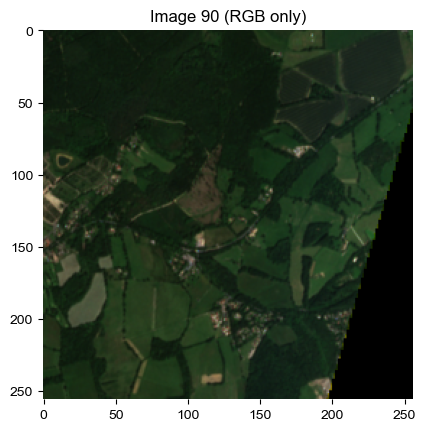

In [39]:
ax = plt.subplot(111)
ds.plot_image(90, ax=ax)